# Siemens 32 Channel QA History

In [5]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd

from lxml import etree

import shlex
import re
from glob import glob
from base64 import b64decode
from os.path import join, dirname
import os

import dateutil
from datetime import datetime
print('Imports')

Imports


In [6]:
def get_coil_name(xmlfile):
    '''Returns name of coil from Siemens local coil QA xml file 
    '''
    root = etree.parse(xmlfile).getroot()
    return dict(token.split(':') for token in shlex.split(root.get('Tags')))['Coil']


def time_stamp(path):
    '''Raw underscore delimited timestamp string encoded in the filename.
       Finds the date string component in the given path.
    '''
    def split_all(path):
        h, t = os.path.split(path)
        return split_all(h) + [t] if h else [t]

    x = re.compile('20......_......_......Z')
    return filter(x.match, split_all(path))[0]


def snr_values(root):
    '''The snr values alone extracted fom the <Numeric> tags with the appropriate ID.
    '''
    snr = {}
    numerics = [numeric for numeric in root.findall('Numeric') if numeric.get('ID').endswith('.SN')]
    for numeric in numerics:
        id_ =  numeric.get('ID')
        value = numeric.find('Value')
        if value is not None:
            coil_element = id_.split('.')[1].split('-')[-4]
            snr[coil_element] = float(value.text)
    return snr

def get_snr_history(coil_name, datadir='.', start=None):
    '''Return a Pandas dataframe with data for Siemens QA on a named coil.
       The root directory (the parent of the 'MrSeso' directory) is specified.
       If a start date (datatime) is specified then results will be returned after that date only.
    '''
    glob_pattern = join(datadir, 'MrSeso', 'site', 'Reports', 'Workflows', 'QA', '*', 'SfpCoilCheckLocalCoils', '*Z.xml')
    files = sorted([
        xmlfile for xmlfile in glob(glob_pattern)
        if get_coil_name(xmlfile) == coil_name
    ], key=time_stamp)
    
    assert files

    results = []
    timestamps = []
    for f in files:
        root = etree.parse(f).getroot()
        results.append(snr_values(root))
        timestamps.append(dateutil.parser.parse(' '.join(time_stamp(f).split('_')[:2])))
        
    assert results and timestamps
    
    df = pd.DataFrame(results, index=timestamps)
    df = df.dropna()
    
    if start is not None:
        start = df.index.searchsorted(start_date)
        df = df.ix[start:]
    return df

print('Functions')

Functions


####Service data xml files

In [7]:
data_dir = 'MriService20150413'
coil_name = 'Head_32'
start_date = datetime(2013, 9, 1)
print('Coil is "%s", Start date is %s' % (coil_name, start_date.strftime('%d-%b-%Y')))

Coil is "Head_32", Start date is 01-Sep-2013


####Extract data

In [8]:
df = get_snr_history(coil_name, datadir=data_dir, start=start_date)
df[['H%d' % i for i in range(1, 21)]].tail()

H1    H2    H3    H4    H5    H6    H7    H8    H9  \
2015-02-16 09:31:35  32.9  51.3  91.7  79.4  57.6  72.0  82.0  91.9  88.2   
2015-02-16 10:48:11  37.0  57.0  96.9  84.2  61.5  74.1  99.6  98.5  82.4   
2015-02-16 12:14:41  33.1  55.1  99.8  82.9  58.9  76.2  91.9  96.6  80.8   
2015-03-02 15:17:02  35.1  55.6  93.1  77.7  58.3  77.5  92.1  94.6  79.6   
2015-03-09 15:57:15  32.5  60.4  90.0  73.7  52.4  67.9  89.3  98.8  84.1   

                      H10   H11   H12   H13   H14   H15   H16    H17   H18  \
2015-02-16 09:31:35  88.3  36.7  37.3  39.5  33.9  63.3  59.4   92.9  59.6   
2015-02-16 10:48:11  80.0  33.3  32.5  37.7  34.3  69.2  68.1   95.0  56.3   
2015-02-16 12:14:41  79.1  33.2  33.4  39.9  32.1  63.2  61.1   98.0  59.3   
2015-03-02 15:17:02  75.5  33.0  31.9  36.9  32.6  65.3  67.4  100.4  57.7   
2015-03-09 15:57:15  73.3  29.0  29.0  33.1  30.0  62.4  65.9  108.2  63.0   

                      H19   H20  
2015-02-16 09:31:35  58.3  43.2  
2015-02-16 10:48:11  58.0  42.0  
2015-02-16 12:14:41  60.7  43.0  
2015-03-02 15:17:02  56.0  40.1  
2015-03-09 15:57:15  59.4  38.0

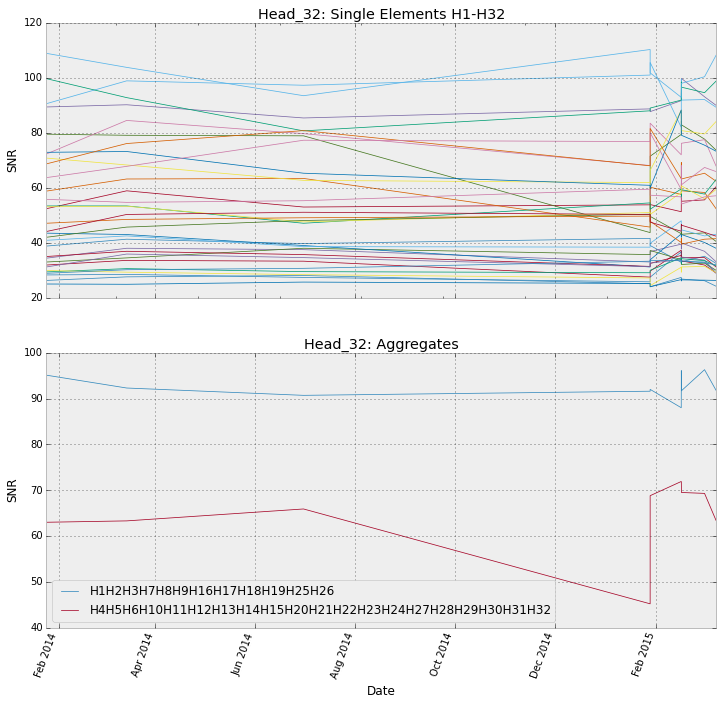

In [9]:
# Values for single coil elements (the legend is a bit too big)
selector = ['H%d' % i for i in range(1, 33)]
df_simple = df[selector]
df_composite = df.drop(selector, axis=1)

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
df_simple.plot(
    ax=axs[0],
    rot=70,
    legend=False,
    title='Head_32: Single Elements %s-%s' % (selector[0], selector[-1]),
)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('SNR')

df_composite.plot(
    ax=axs[1],
    rot=70,
    title='Head_32: Aggregates')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('SNR');


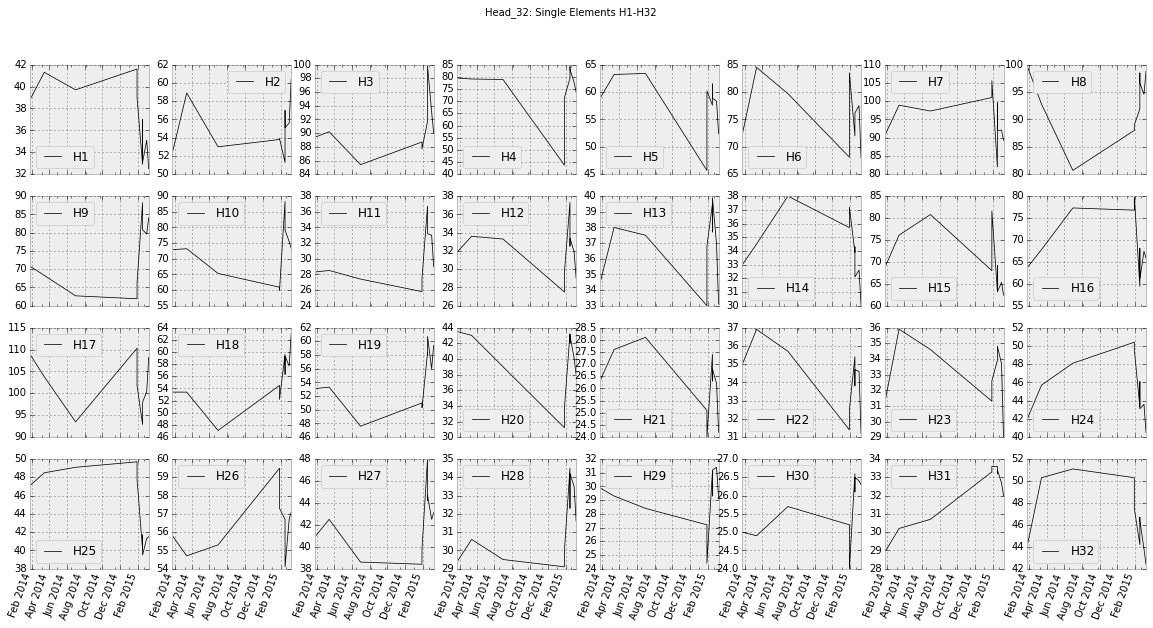

In [19]:
df_simple.plot(
    subplots=True,
    sharex=True,
    layout=(4, 8),
    figsize=(20, 10),
    rot=70,
    legend=True,
    title='Head_32: Single Elements %s-%s' % (selector[0], selector[-1]),
)
plt.show()
